# Report
## Blur detection
##### Alexander Abugaliev

Целью моей работы является создание классификатора, который может разделить пиксели размытой (в результате расфокусировки или движения) части изображения от чистой. Основой для своей работы я выбрал статью http://www.shijianping.me/blur_cvpr14.pdf , т.к. она предоставляет наилучшее решение этой проблемы из тех, которые я нашел. Кроме того к статье приложена ссылка на датасет и код, демонстрирующий работу классификатора http://www.cse.cuhk.edu.hk/leojia/projects/dblurdetect/ .

В ходе анализа кода я заметил, что для построения конечного решения используется преобразование результатов трех наивных байесовских классификаторов построенных на одинаковых признаках. Но признаки для каждого классификатора рассчитаны по характеристикам пикселей в областях разного размера. Т.е. признаки для каждого пикселя рассчитывались по его окресности скользящим окном разного размера ($11 * 11$,$15 * 15$,$21 * 21$).

Основным недостатком данного решения является классификация областей одного цвета (например синяя стена), как размытых, хотя они не движутся и находятся в фокусе. Я решил попытатся исправить этот недостаток. Я не слишком силен в оптике поэтому изменять исходные признаки не решился. Однако добавил один свой основанный стандатрном отклонении насыщенности в окресности пикселя. На эту мысль меня навела эта статья: http://www.cse.cuhk.edu.hk/leojia/all_final_papers/blur_detect_cvpr08.pdf. В ней предлагается использовать максимум насыщенности в области, однако я не заметил существенных распределении этого признака в чистых и размытых областях. Вместо этого я использовал стандарное отклонение, из его гистограммы видно, что распределение призанка уменьшает свой разброс в порядке чистый -> размытый -> одноцветный.
<img src="./report/saturation_hist.png">



Однако я являють специалистом в машинном обучении и решил изменить эту часть работы. В настоящее время наивные байесовские классификаторы практически не используются в машинном обучении в чистом виде, т.к. обычно уступают в качестве другим моделям. И в первую очередь я решил заменить эти классификаторы на свои. Я построил свои решения на базе линейныйх моделей (логистическая регрессия, svm) и нелинейных (линейная, логистическая регрессия и svm на полиномиальных признаках, случайный лес, градиентный бустинг). Лучшие результаты показала модель градиентного бустинга и я заменил ей все три наивных байессовских классификатора.

Однако использовав свои модели в сочетании с их multiscale interface. Я получил не слишном хорошие результаты. Я не замерял их метрики качества, однако очевидно выглядели ошибочными.

Я зудамался, а можно ли обучить классификаторы опираясь вычисляя ошибку из multiscale interface, а не предсказание самого классификатора. Увы это оказалось слишком сложным и громоздким решением. Тогда я решил пойти другим полем и используя технологию стэкинга попробавать создать свой аналогичный интерфейс. Для стекинга я использовал результаты своих классификоторов в окресности размером $5*5$ от пикселя, учитывая таким образом окружение пикся. 

Немного подробнее о классификаторах. Я их построил 9, т.е. по 3 для каждого размера.
* первый классификатор трехклассовый clear/blur/solid.
* второй классификатор двуклассовый clear/blur.
* третий классификатор двуклассовый nonsolid/solid.
Т.к. сумма вероятностей классов должна быть 1 первый классификатор более осторожен в своих выводах, в сравнении с остальными двумя. Над ними я построил два стекинговых классификатора (для сравнения) один из них clear/blur/solid классификаторами, второй над результатами clear/blur и вероятностями solid из классификатора nonsolid/solid, в дальнейшем он будет называться clear/blur+solid.

Проанализируем результаты.

## Precition-recal curve

In [6]:
predictions = pickle.load(open('./extracted/predictions.bin','rb'))

In [7]:
predictions.keys()

dict_keys(['c/b/s classifier', 'base classifier', 'c/b+s classifier', 'ground truth'])

In [8]:
precision_base,recall_base,_ = precision_recall_curve(predictions['ground truth'],predictions['base classifier'])

In [9]:
precision_cbs,recall_cbs,_ = precision_recall_curve(predictions['ground truth'],predictions['c/b/s classifier'])

In [10]:
precision_cbps,recall_cbps,_ = precision_recall_curve(predictions['ground truth'],predictions['c/b+s classifier'])

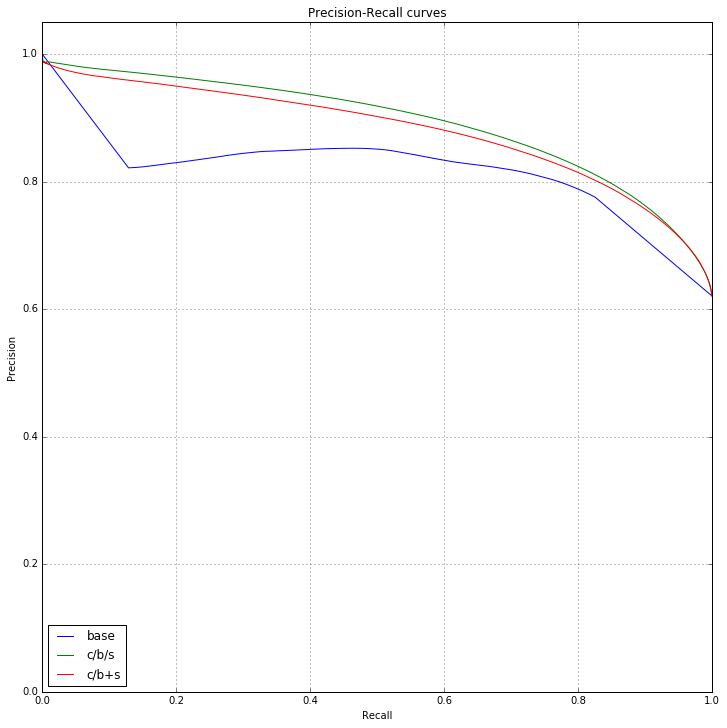

In [12]:
plt.figure(1,figsize=(12,12))
plt.plot(recall_base, precision_base, label='base')
plt.plot(recall_cbs, precision_cbs, label='c/b/s')
plt.plot(recall_cbps, precision_cbps, label='c/b+s')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curves')
plt.grid()
plt.legend(loc="lower left")

# Scores

In [13]:
accuracy_base = accuracy_score(predictions['ground truth'],predictions['base classifier']>0.5)
accuracy_cbs  = accuracy_score(predictions['ground truth'],predictions['c/b/s classifier']>0.5)
accuracy_cbps = accuracy_score(predictions['ground truth'],predictions['c/b+s classifier']>0.5)
print ('Base clasifier accuracy: ',accuracy_base)
print ('Clear/blur/solid classifier accuracy:',accuracy_cbs)
print ('Clear/blur+solid classifier accuracy:',accuracy_cbps)

Base clasifier accuracy:  0.665458414568
Clear/blur/solid classifier accuracy: 0.76782908443
Clear/blur+solid classifier accuracy: 0.76591661831


In [14]:
roc_auc_base = roc_auc_score(predictions['ground truth'],predictions['base classifier'])
roc_auc_cbs  = roc_auc_score(predictions['ground truth'],predictions['c/b/s classifier'])
roc_auc_cbps = roc_auc_score(predictions['ground truth'],predictions['c/b+s classifier'])
print ('Base clasifier f_score: ',roc_auc_base)
print ('Clear/blur/solid classifier f_score:',roc_auc_cbs)
print ('Clear/blur+solid classifier f_score:',roc_auc_cbps)

Base clasifier f_score:  0.762261062259
Clear/blur/solid classifier f_score: 0.841543152047
Clear/blur+solid classifier f_score: 0.830196086921


# Statistical scores (througth all images)

### Accuracy

In [15]:
accuracy_scores_base = []
accuracy_scores_cbs = []
accuracy_scores_cbps = []
for target in dirlist:
    prediction = get_predictions(target)
    precision_gt = (np.array(prediction[4].reshape(1,prediction[4].shape[0]*prediction[4].shape[1]).tolist()[0])/255).round()
    precision_base = np.array(prediction[3].reshape(1,prediction[4].shape[0]*prediction[3].shape[1]).tolist()[0])>0.5
    precision_cbs = np.array(prediction[1].reshape(1,prediction[1].shape[0]*prediction[1].shape[1]).tolist()[0])>0.5
    precision_cbps = np.array(prediction[2].reshape(1,prediction[2].shape[0]*prediction[2].shape[1]).tolist()[0])>0.5
    accuracy_scores_base.append(accuracy_score(precision_gt,precision_base))
    accuracy_scores_cbs.append(accuracy_score(precision_gt,precision_cbs))
    accuracy_scores_cbps.append(accuracy_score(precision_gt,precision_cbps))

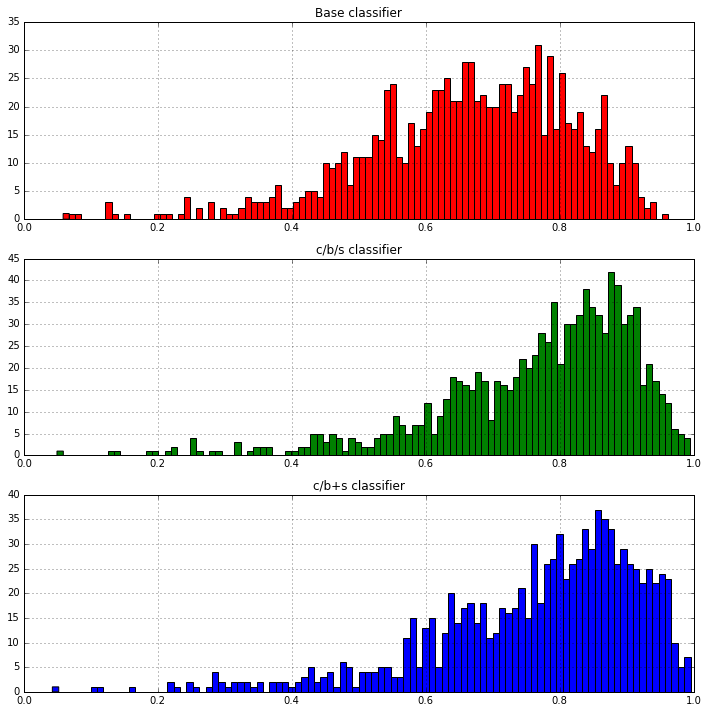

In [16]:
plt.figure(2,figsize=(12,12))
plt.subplot(311)
plt.title('Base classifier')
plt.hist(accuracy_scores_base,color='red',bins=100)
plt.grid()
plt.subplot(312)
plt.title('c/b/s classifier')
plt.hist(accuracy_scores_cbs,color='green',bins=100)
plt.grid()
plt.subplot(313)
plt.title('c/b+s classifier')
plt.hist(accuracy_scores_cbps,color='blue',bins=100)
plt.grid()

t-criteria for mean

In [17]:
u = np.mean(accuracy_scores_base)
S = np.std(accuracy_scores_base,ddof=1)/np.sqrt(len(accuracy_scores_base))
interval = _tconfint_generic(u,S,len(accuracy_scores_base)-1,0.05,'two-sided')
print('Mean accuracy for base classifier in ', interval,' with p-value 0.05')

Mean accuracy for base classifier in  (0.6557049319351228, 0.67462061949629148)  with p-value 0.05


In [18]:
u = np.mean(accuracy_scores_cbs)
S = np.std(accuracy_scores_cbs,ddof=1)/np.sqrt(len(accuracy_scores_cbs))
interval = _tconfint_generic(u,S,len(accuracy_scores_cbs)-1,0.05,'two-sided')
print('Mean accuracy for c/b/s classifier in ', interval,' with p-value 0.05')

Mean accuracy for c/b/s classifier in  (0.76045624499991782, 0.77879561121664509)  with p-value 0.05


In [19]:
u = np.mean(accuracy_scores_cbps)
S = np.std(accuracy_scores_cbps,ddof=1)/np.sqrt(len(accuracy_scores_cbps))
interval = _tconfint_generic(u,S,len(accuracy_scores_cbps)-1,0.05,'two-sided')
print('Mean accuracy for c/b+s classifier in ', interval,' with p-value 0.05')

Mean accuracy for c/b+s classifier in  (0.75692024198271213, 0.77632515223467036)  with p-value 0.05


### ROC_AUC

In [20]:
roc_auc_scores_base = []
roc_auc_scores_cbs = []
roc_auc_scores_cbps = []
for target in dirlist:
    prediction = get_predictions(target)
    precision_gt = (np.array(prediction[4].reshape(1,prediction[4].shape[0]*prediction[4].shape[1]).tolist()[0])/255).round()
    precision_base = np.array(prediction[3].reshape(1,prediction[4].shape[0]*prediction[3].shape[1]).tolist()[0])>0.5
    precision_cbs = np.array(prediction[1].reshape(1,prediction[1].shape[0]*prediction[1].shape[1]).tolist()[0])>0.5
    precision_cbps = np.array(prediction[2].reshape(1,prediction[2].shape[0]*prediction[2].shape[1]).tolist()[0])>0.5
    roc_auc_scores_base.append(roc_auc_score(precision_gt,precision_base))
    roc_auc_scores_cbs.append(roc_auc_score(precision_gt,precision_cbs))
    roc_auc_scores_cbps.append(roc_auc_score(precision_gt,precision_cbps))

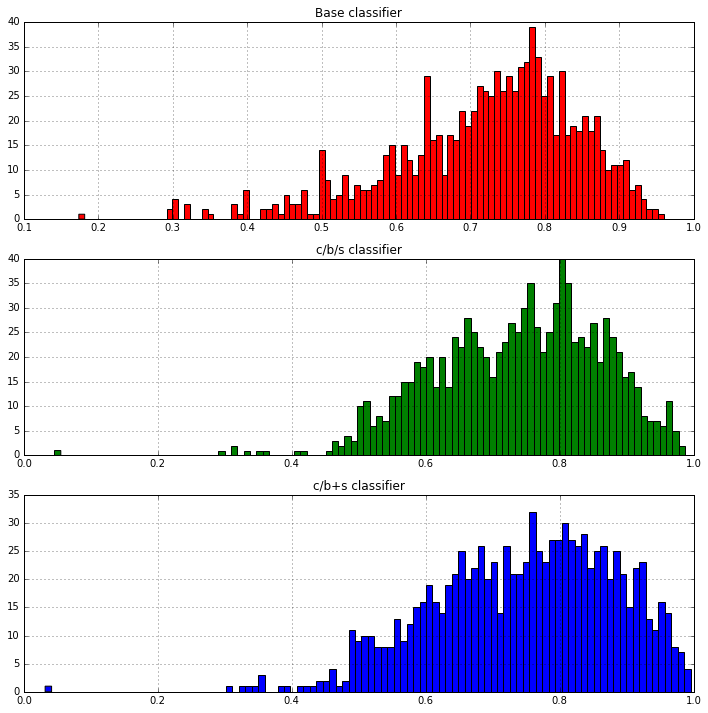

In [21]:
plt.figure(2,figsize=(12,12))
plt.subplot(311)
plt.title('Base classifier')
plt.hist(roc_auc_scores_base,color='red',bins=100)
plt.grid()
plt.subplot(312)
plt.title('c/b/s classifier')
plt.hist(roc_auc_scores_cbs,color='green',bins=100)
plt.grid()
plt.subplot(313)
plt.title('c/b+s classifier')
plt.hist(roc_auc_scores_cbps,color='blue',bins=100)
plt.grid()

In [22]:
u = np.mean(roc_auc_scores_base)
S = np.std(roc_auc_scores_base,ddof=1)/np.sqrt(len(roc_auc_scores_base))
interval = _tconfint_generic(u,S,len(roc_auc_scores_base)-1,0.05,'two-sided')
print('Mean accuracy for base classifier in ', interval,' with p-value 0.05')

Mean accuracy for base classifier in  (0.71489539584018436, 0.73037542487002061)  with p-value 0.05


In [23]:
u = np.mean(roc_auc_scores_cbs)
S = np.std(roc_auc_scores_cbs,ddof=1)/np.sqrt(len(roc_auc_scores_cbs))
interval = _tconfint_generic(u,S,len(roc_auc_scores_cbs)-1,0.05,'two-sided')
print('Mean accuracy for c/b/s classifier in ', interval,' with p-value 0.05')

Mean accuracy for c/b/s classifier in  (0.72925707418759367, 0.74471856242248546)  with p-value 0.05


In [24]:
u = np.mean(roc_auc_scores_cbps)
S = np.std(roc_auc_scores_cbps,ddof=1)/np.sqrt(len(roc_auc_scores_cbps))
interval = _tconfint_generic(u,S,len(roc_auc_scores_cbps)-1,0.05,'two-sided')
print('Mean accuracy for c/b+s classifier in ', interval,' with p-value 0.05')

Mean accuracy for c/b+s classifier in  (0.7375104004454287, 0.75431516680183197)  with p-value 0.05


# Examples

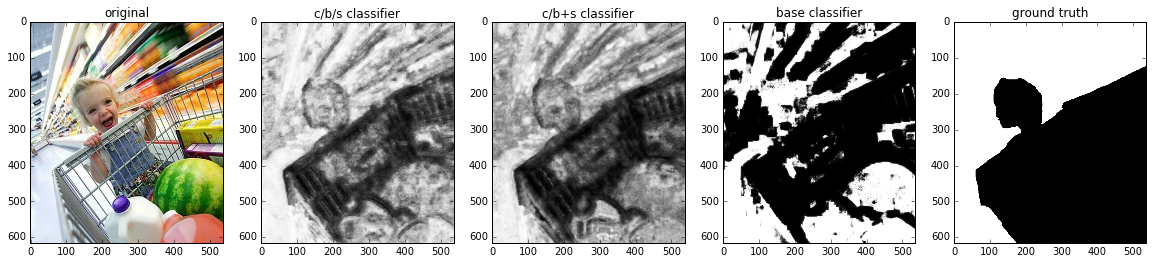

In [25]:
show_predictions('motion0012')

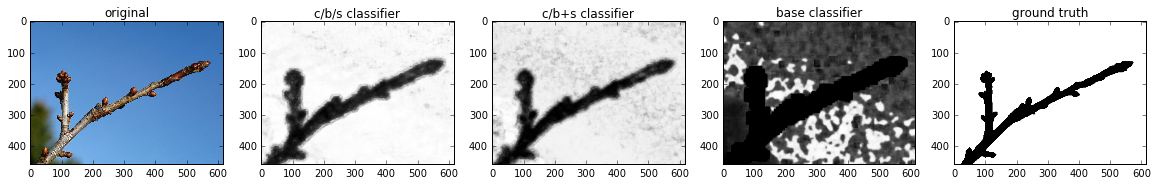

In [26]:
show_predictions('out_of_focus0303')

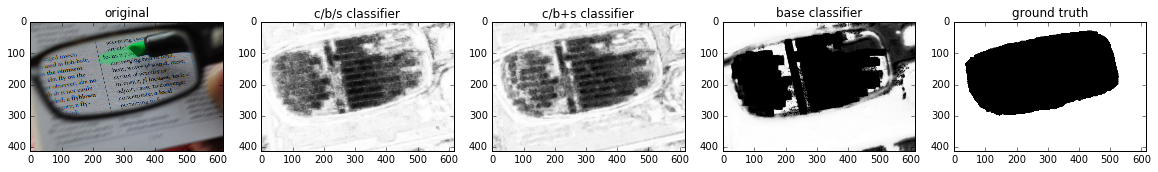

In [27]:
show_predictions('out_of_focus0385')

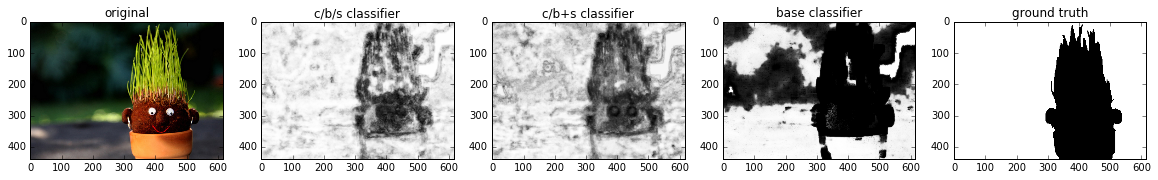

In [28]:
show_predictions('out_of_focus0407')

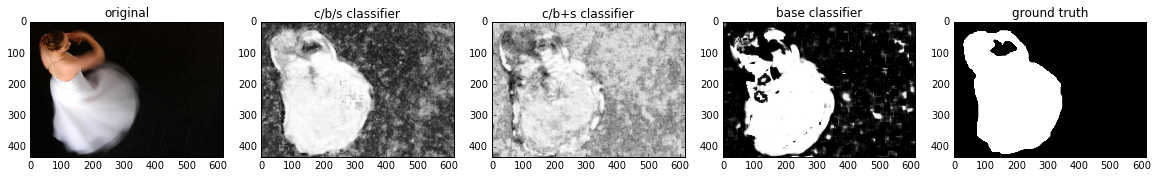

In [29]:
show_predictions('motion0009')

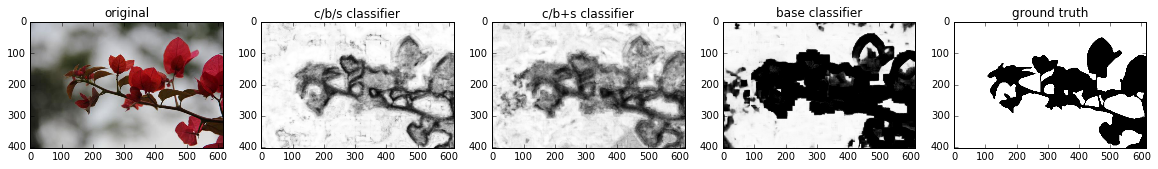

In [30]:
show_predictions('out_of_focus0026')

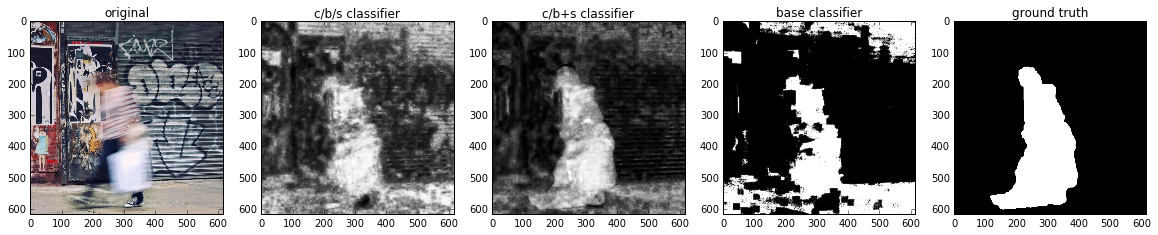

In [31]:
show_predictions('motion0071')

# Conclusion

По итогам работы мне не удалось создать классификатор, эффективно решающий размытые и одноцветные регионы изображения, что подталкивает к мысли о неразделимости выборки в данном признаковом пространстве. Тем более что гистаграммы признаков указывают на это. Хотя возможно их можно разделить используя информацию о контектсте (окружении) пикселя, для этого можно попробовать использовать сверточные нейронные сети, подавая на вход не только оригинальное изображение, но и данные признаки. Формируя таким образом 7 слойное изображение на входе. Перспективной в данном варианте служит сеть U-net использующая 3 сверточных слоя и получая таким образом информацию об окружении пикселя, как минимум в радиусе 27 пикселов.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve
from statsmodels.stats.weightstats import _tconfint_generic
from scipy import misc
import pickle
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
dirlist = os.listdir('./extracted')[:1000]

In [3]:
def get_predictions(target):
    predictions = pickle.load(open('./extracted/'+target+'/predictions.bin','rb'))
    return predictions

In [4]:
def show_predictions(target):
    predictions = pickle.load(open('./extracted/'+target+'/predictions.bin','rb'))
    fig, axes = plt.subplots(1,5,figsize=(20,20))
    axes[0].imshow(predictions[0])
    axes[0].set_title('original')
    axes[1].imshow(predictions[1],cmap='gray')
    axes[1].set_title('c/b/s classifier')
    axes[2].imshow(predictions[2],cmap='gray')
    axes[2].set_title('c/b+s classifier')
    axes[3].imshow(predictions[3],cmap='gray')
    axes[3].set_title('base classifier')
    axes[4].imshow(predictions[4],cmap='gray')
    axes[4].set_title('ground truth')

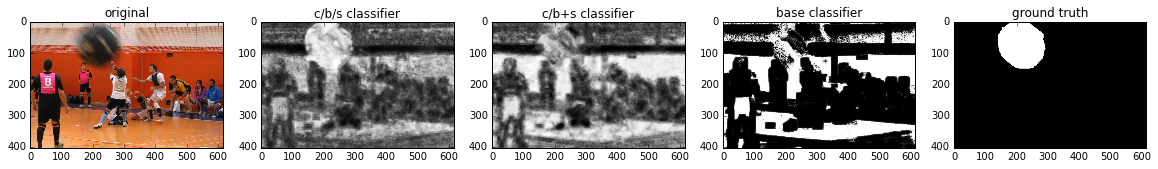

In [5]:
show_predictions('motion0006')